# All-e market research
This notebook contains the data analysis for the all-e market research.  

## contents
1) Loading daily aggregated data from Clickhouse / local.
2) Fitting a heat demand vs. ambiant temperature model per cic.
3) Fitting a water temp vs. ambiant temperature model per cic.
4) Extrapolating both to make a plot at -10, -5 and 0 degrees for each cic.
5) Plotting in the same figure the maximum available heat production.


to do:
- filter out cic's with more than 10 missing days (cic swaps?)
- check filtering of outliers, especially for water supply model
- check if we can filter out houses in a certain way
- is there a way to make sure that we are looking an accurate representation?
- is 5kWh going to make a significant impact?

In [2]:
import clickhouse_connect
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import os
from os import path
from plotly import colors
import plotly.express as px 
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
from sklearn.linear_model import TheilSenRegressor, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pyod.models.cd import CD
from pyod.models.thresholds import FWFM
from scipy.optimize import curve_fit
import numpy as np
from sqlalchemy import create_engine
from urllib.parse import urlparse
from requests import HTTPError
from math import radians, cos, sin, asin, sqrt
from knmy import knmy
import pgeocode
from datetime import datetime


# PLotting theme
pio.templates.default = "plotly_white"

In [3]:
# Load username and password from .env file
env_path = Path('../') / '.env'
load_dotenv(env_path)

True

## 2) data cleaning and definition of models

In [ ]:
def plot_metric_distribution(df, metric_name, savings_thresholds, actual_savings_col='actualSavings'):
    """
    Plot the distribution of a given metric for different savings thresholds
    Inputs:
        df: dataframe
        metric_name: name of the metric
        savings_thresholds: list of savings thresholds
        actual_savings_col: name of the column containing the actual savings
    """
    subplot_titles = []
    for savings_threshold in savings_thresholds:
        df_tmp = df[df[actual_savings_col] >= savings_threshold]
        subplot_titles.append(f"Savings Threshold: {savings_threshold}: number of CiCs: {len(df_tmp)}, Savings mean +- 3 sigma: {df_tmp[metric_name].mean():.2f} +- {3 * df_tmp[metric_name].std():.2f}")

    # Create a figure with subplots
    fig = make_subplots(rows=len(savings_thresholds), cols=1, subplot_titles=subplot_titles, vertical_spacing=0.1)

    # Iterate over each savings threshold
    for i, threshold in enumerate(savings_thresholds):
        # Filter the dataframe to include only rows with savings above the threshold
        df_filtered = df[df[actual_savings_col] >= threshold]

        # Add a histogram of the metric to the subplot
        fig.add_trace(px.histogram(df_filtered, x=metric_name, nbins=50).data[0], row=i+1, col=1)

        # Set the subplot title
        fig.update_yaxes(title_text=f"Count", row=i+1, col=1, matches='y')
        fig.update_xaxes(title_text=metric_name, row=i+1, col=1, matches='x')

    # Update the figure layout
    fig.update_layout(height=800, title_text=f"Distribution of {metric_name} by Savings Threshold")
    fig.show()


In [ ]:
def plot_actual_and_estimated_by_cic(df, actual_col, estimated_col, title):
    """
    Plot the actual and estimated values of a given metric for each CiC
    Inputs:
        df: dataframe
        actual_col: name of the column containing the actual values
        estimated_col: name of the column containing the estimated values
        title: title of the plot
    """
    # Get a list of unique CiCs
    cics = df['cic_id'].unique()

    # Create a figure with two subplots for each CiC
    fig = make_subplots(rows=2, cols=1, subplot_titles=[f"Actual and Estimated {actual_col}", f"Cumulative Actual and Estimated {actual_col}"])

    # Iterate over each CiC
    for i, cic in enumerate(cics):
        # Filter the dataframe to include only rows for the current CiC
        df_cic = df[df['cic_id'] == cic]

        # Set the color of the traces based on the index of the current CiC in the list of unique CiCs
        color = px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]

        # Add a scatter plot of actual vs estimated metric to the first subplot
        fig.add_trace(go.Scatter(x=df_cic['date'], y=df_cic[actual_col], mode='markers', name=f'{cic} Actual', legendgroup=cic, visible='legendonly', marker_color=color), row=1, col=1)
        fig.add_trace(go.Scatter(x=df_cic['date'], y=df_cic[estimated_col], mode='lines', name='Estimated', legendgroup=cic, visible='legendonly', line_color=color), row=1, col=1)

        # Add a scatter plot of cumulated actual vs estimated metric to the second subplot
        fig.add_trace(go.Scatter(x=df_cic['date'], y=df_cic[actual_col].cumsum(), mode='markers', name='Actual', legendgroup=cic, visible='legendonly', marker_color=color), row=2, col=1)
        fig.add_trace(go.Scatter(x=df_cic['date'], y=df_cic[estimated_col].cumsum(), mode='lines', name='Estimated', legendgroup=cic, visible='legendonly', line_color=color), row=2, col=1)

    # Update the subplot layout
    fig.update_xaxes(title_text='Date', row=1, col=2)
    fig.update_yaxes(title_text=actual_col, row=1, col=1)
    fig.update_yaxes(title_text=f'Cumulative {actual_col}', row=2, col=1)
    fig.update_xaxes(matches='x')

    # Update the figure layout
    fig.update_layout(height=800, title_text=title)

    # Show the plot
    fig.show()


In [58]:
# Define the model functions and data filters
# - Heat demand model: Q_house = c0 * Ta + c1
# - HP heat ratio model: hpHeatRatio = 1 / (1 + exp(-(c2 * Ta + c3)))
# - Summer mode model: summerMode = 1 / (1 + exp((c4 * Ta + c5)))
# - COP model: COP = c6 * Ta + c7
# - HP heat delivered model: Q_hp = Q_house * hpHeatRatio * summerMode
# - HP energy consumed model: E_hp = Q_hp / COP
# - Savings model: savings = hpHeatRatio * Q_house * summerMode * ((cost_gas / calorific_value_gas) - cost_electricity / COP)
# - Filter outliers: Use CD with FWFM to remove outliers
# - Filter data for COP model: Remove rows where Q_hp < min_Q_hp, COP < min_COP or > max_cop
# - Filter data for heat demand model: Remove rows where Q_house < min_Q_house
# - Filter data for HP heat ratio model: Remove rows where Q_house < min_Q_house
# - Filter data for summer mode model: Remove rows where Q_hp < min_Q_hp
# - Filter data for complete model: Remove rows where Q_hp < min_Q

def heat_demand_model(Ta, c0, c1):
    return c0 * Ta + c1

def hp_heat_ratio_model(Ta, c2, c3):
    return 1 / (1 + np.exp(-(c2 * Ta + c3)))

def summer_mode_model(Ta, c4, c5):
    return ( (1 / (1 + np.exp((c4 * Ta + c5)))))

def cop_model(Ta, c6, c7):
    return c6 * Ta + c7

def hp_heat_delivered_model(Ta, heat_demand_model_params, hp_heat_ratio_model_params, summer_mode_model_params):
    return heat_demand_model(Ta, *heat_demand_model_params) * hp_heat_ratio_model(Ta, *hp_heat_ratio_model_params) * summer_mode_model(Ta, *summer_mode_model_params)

def hp_energy_consumed_model(Ta, heat_demand_model_params, hp_heat_ratio_model_params, summer_mode_model_params, cop_model_params):
    return hp_heat_delivered_model(Ta, heat_demand_model_params, hp_heat_ratio_model_params, summer_mode_model_params) / cop_model(Ta, *cop_model_params)

def savings_model(Ta, heat_demand_model_params, hp_heat_ratio_model_params, summer_mode_model_params, cop_model_params, min_cop=1):
        cost_gas = 1.46 # €/m3
        cost_electricity = 0.36 # €/kWh
        calorific_value_gas = 8.8 # kWh/m3
        return hp_heat_delivered_model(Ta, heat_demand_model_params, hp_heat_ratio_model_params, summer_mode_model_params) * ((cost_gas / calorific_value_gas) - (cost_electricity / np.clip(cop_model(Ta, *cop_model_params), min_cop, np.Inf)))

# Define the model function
def savings_model_detailed(Ta, heat_demand_model_params, hp_heat_ratio_model_params, summer_mode_model_params, cop_model_params, min_cop=1):
    house_heat_demand = heat_demand_model(Ta, *heat_demand_model_params)
    hp_heat_delivered = hp_heat_ratio_model(Ta, *hp_heat_ratio_model_params) * house_heat_demand * summer_mode_model(Ta, *summer_mode_model_params)
    hp_energy_consumed = hp_heat_delivered / np.clip(cop_model(Ta, *cop_model_params), min_cop, np.Inf)
    savings = savings_model(Ta, heat_demand_model_params, hp_heat_ratio_model_params, summer_mode_model_params, cop_model_params, min_cop=min_cop)
    return savings, house_heat_demand,hp_heat_delivered, hp_energy_consumed

def filterOutliers(df, Q_hpCol='Q_hp', Q_houseCol='Q_house', min_Q = 1, inplace=False):
    if inplace:
        df_cic = df
    else:
        df_cic = df.copy()
    
    # Remove rows where Q < min_Q
    df_cic = df_cic[df_cic[Q_hpCol] > min_Q]
    df_cic = df_cic[df_cic[Q_houseCol] > min_Q]

    # Use CD with FWFM to remove outliers
    X = df_cic[[Q_hpCol, Q_houseCol]].to_numpy()
    model = CD(contamination=FWFM())
    model.fit(X)
    y_pred = model.predict(X)
    df_cic['outlier'] = y_pred
    df_cic = df_cic[df_cic['outlier'] == 0]
    return df_cic

def filterDataForCopModel(df, min_Q_hp=2, min_COP = 0.5, max_cop = 15, inplace=False):
    if inplace:
        df_heating = df
    else:
        df_heating = df.copy()

    # Remove rows where Q_hp < min_Q_hp
    df_heating = df[(df['Q_hp'] >= min_Q_hp)]

    # Remove rows where COP < min_COP or > max_cop
    df_heating = df_heating[(df_heating['COP'] >= min_COP) & (df_heating['COP'] <= max_cop)]
    
    # Sort df_heating by ambientTemperature
    df_heating = df_heating.sort_values(by=['ambientTemperature'])
    return df_heating

def filterDataForHeatDemandModel(df, min_Q_house=3, inplace=False):
    if inplace:
        df_ss = df
    else:
        df_ss = df.copy()
    
    # Remove rows where Q_house < min_Q_house
    df_ss = df_ss[(df_ss['Q_house'] >= min_Q_house)]
    # # Remove rows where roomTemperatureError > 1.0 or < -1.0
    # df_ss = df_ss[(df_ss['roomTemperatureError'] <= room_temperature_error_threshold) &
    # (df_ss['roomTemperatureError'] >= -room_temperature_error_threshold)]
    return df_ss

def filterDataForHpRatioModel(df_cic, min_Q_house=3, inplace=False, hpRatioCol='hpHeatRatio', Q_houseCol='Q_house'):
    if not inplace:
        df_cic = df_cic.copy()
    
    df_cic = df_cic[df_cic[Q_houseCol] > min_Q_house]
    df_cic[hpRatioCol] = df_cic[Q_houseCol] / df_cic['Q_hp']
    
    return df_cic


def filterDataForSummerModeModel(df_cic, min_Q_hp = 3, inplace=False):
    if not inplace:
        df_cic = df_cic.copy()

    df_cic['summerMode'] = (df_cic['Q_hp'] < min_Q_hp).astype(int)
    return df_cic

def filterDataForCompleteModel(df_cic, min_Q = 3, inplace=False):
    if not inplace:
        df_cic = df_cic.copy()
    
    df_cic = df_cic[df_cic['Q_hp'] > min_Q]
    return df_cic

In [ ]:
def estimate_model_parameters(df_cic):
    """
    Estimate the parameters of the complete model
    Inputs:
        df_cic: dataframe containing the data for a single CiC
    Outputs:
        popt: array of parameter values
        pcov: covariance matrix
    """
    
    # Estimate parameters of individual components of the model
    p0_heat_demand = [-4.4, 72.2]
    df_cic_heat_demand = filterOutliers(df_cic, inplace=False)
    popt_heat_demand, _ = curve_fit(heat_demand_model, df_cic_heat_demand['ambientTemperature'], df_cic_heat_demand['Q_house'], p0=p0_heat_demand)

    p0_hp_heat_ratio = [0.26, 0.79]
    df_cic_hp_heat_ratio = filterOutliers(df_cic, inplace=False)
    df_cic_hp_heat_ratio = filterDataForHpRatioModel(df_cic_hp_heat_ratio, inplace=False)
    popt_hp_heat_ratio, _ = curve_fit(hp_heat_ratio_model, df_cic_hp_heat_ratio['ambientTemperature'], df_cic_hp_heat_ratio['Q_hp'] / df_cic_hp_heat_ratio['Q_house'], p0=p0_hp_heat_ratio)

    df_cic_summer_mode = filterDataForSummerModeModel(df_cic, inplace=False)
    # Use sklearn LogisticRegression to fit a logistic model to summerMode as a function of ambientTemperature
    X = df_cic_summer_mode['ambientTemperature'].to_numpy().reshape(-1, 1)
    y = df_cic_summer_mode['summerMode'].to_numpy()
    modelSummerMode = make_pipeline(LogisticRegression(random_state=0, C=1e5, class_weight={0: 0.5, 1: 0.5})).fit(X, y)
    popt_summer_mode = np.concatenate([modelSummerMode['logisticregression'].coef_[0], modelSummerMode['logisticregression'].intercept_])

    p0_cop = [0.22, 2.25]
    df_cic_cop = filterOutliers(df_cic, inplace=False)
    df_cic_cop = filterDataForCopModel(df_cic_cop, inplace=False)
    popt_cop, _ = curve_fit(cop_model, df_cic_cop['ambientTemperature'], df_cic_cop['COP'], p0=p0_cop)

    # Define initial guess for model parameters
    p0 = np.concatenate([popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode, popt_cop])
    
    # Define bounds for model parameters
    # bounds = ([-20, 20, 0, -1, -3000, -2000, -1, -7], 
    #           [-1, 400, 3, 14, np.Inf, 2000, 1, 7])
    # bounds = ([-20, 20, 0, -2, 0.15, -30, -1, -7], 
    #           [-1, 400, 2, 4, 2.0, -1, 1, 7])
    bounds = ([-20, 20, popt_hp_heat_ratio[0], popt_hp_heat_ratio[1], popt_summer_mode[0], popt_summer_mode[1], -1, -7], 
              [-1, 400, popt_hp_heat_ratio[0] + 1e-6, popt_hp_heat_ratio[1] + 1e-6, popt_summer_mode[0] + 1e-6, popt_summer_mode[1] + 1e-6, 1, 7])
    
    if any(p0 < bounds[0]) or any(p0 > bounds[1]):
        print(f"Initial params: {p0} \nBounds: {bounds}")
        return None, None

    # Filter data for complete model
    df_cic_heating = filterDataForCompleteModel(df_cic, inplace=False)

    # Fit the model to the data
    try:
        popt, pcov = curve_fit(savings_model, df_cic_heating['ambientTemperature'], df_cic_heating['savings'], p0=p0, bounds=bounds)
    except ValueError as e:
        print(f"Initial params: {p0} \n{e}")
        return None, None

    # Define parameter names for the complete model
    param_names = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

    # Create a dictionary of parameter names and values for the complete model
    param_dict = {param_names[i]: popt[i] for i in range(len(param_names))}

    return popt, pcov


In [ ]:
def decouple_estimate_model_parameters(df_cic):
    """
    Estimate the parameters of the complete model in a decoupled manner - first estimate the parameters of the individual components of the model and then combine them
    Inputs:
        df_cic: dataframe containing the data for a single CiC
    Outputs:
        popt: array of parameter values
        pcov: covariance matrix
    """
    # Estimate parameters of individual components of the model
    p0_heat_demand = [-4.4, 72.2]
    df_cic_heat_demand = filterOutliers(df_cic, inplace=False)
    df_cic_heat_demand = filterDataForHeatDemandModel(df_cic_heat_demand, inplace=False)
    # popt_heat_demand, _ = curve_fit(heat_demand_model, df_cic_heat_demand['ambientTemperature'], df_cic_heat_demand['Q_house'], p0=p0_heat_demand)
    X = df_cic_heat_demand['ambientTemperature'].to_numpy().reshape(-1, 1)
    y = df_cic_heat_demand['Q_house'].to_numpy()
    modelHeatDemand = TheilSenRegressor(random_state=0).fit(X, y)
    popt_heat_demand = [list(modelHeatDemand.coef_)[0], modelHeatDemand.intercept_]

    p0_hp_heat_ratio = [0.26, 0.79]
    df_cic_hp_heat_ratio = filterOutliers(df_cic, inplace=False)
    df_cic_hp_heat_ratio = filterDataForHpRatioModel(df_cic_hp_heat_ratio, inplace=False)
    popt_hp_heat_ratio, _ = curve_fit(hp_heat_ratio_model, df_cic_hp_heat_ratio['ambientTemperature'], df_cic_hp_heat_ratio['Q_hp'] / df_cic_hp_heat_ratio['Q_house'], p0=p0_hp_heat_ratio)

    df_cic_summer_mode = filterDataForSummerModeModel(df_cic, inplace=False)
    # Use sklearn LogisticRegression to fit a logistic model to summerMode as a function of ambientTemperature
    X = df_cic_summer_mode['ambientTemperature'].to_numpy().reshape(-1, 1)
    y = df_cic_summer_mode['summerMode'].to_numpy()
    modelSummerMode = make_pipeline(LogisticRegression(random_state=0, C=1e5, class_weight={0: 0.5, 1: 0.5})).fit(X, y)
    popt_summer_mode = np.concatenate([modelSummerMode['logisticregression'].coef_[0], modelSummerMode['logisticregression'].intercept_])

    p0_cop = [0.22, 2.25]
    df_cic_cop = filterOutliers(df_cic, inplace=False)
    df_cic_cop = filterDataForCopModel(df_cic, inplace=False)
    # popt_cop, _ = curve_fit(cop_model, df_cic_cop['ambientTemperature'], df_cic_cop['COP'], p0=p0_cop)
    X = df_cic_cop['ambientTemperature'].to_numpy().reshape(-1, 1)
    y = df_cic_cop['COP'].to_numpy()
    modelCOP = TheilSenRegressor(random_state=0).fit(X, y)
    popt_cop = [list(modelCOP.coef_)[0], modelCOP.intercept_]

    # Combine model parameters
    # popt = np.concatenate([popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode, popt_cop])


    return popt_heat_demand, list(popt_hp_heat_ratio), list(popt_summer_mode), list(popt_cop), None

In [ ]:
def evaluate_model(df_test, popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode, popt_cop, inplace=False, min_Q=1):
    """
    Evaluate the complete model on the test data
    Inputs:
        df_test: dataframe containing the test data
        model_params: array of parameter values
        inplace: whether to modify the input dataframe or return a copy
    Outputs:
        df_test: dataframe containing the test data with estimated savings, heat delivered by heatpump, energy consumed by heatpump
        df_result: dataframe containing the metrics
    """
    if not inplace:
        df_test = df_test.copy()

    # Add summer mode column
    df_test['summerMode'] = df_test['Q_hp'].apply(lambda x: 1 if x < min_Q else 0)

    # Calculate estimated savings for each row in the test dataset
    df_test['estimated_savings'], df_test['estimated_house_heat_demand'], df_test['estimated_hp_heat_delivered'], df_test['estimated_hp_energy_consumed'] = savings_model_detailed(df_test['ambientTemperature'], popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode, popt_cop)

    # Calculate RMS error
    rms_error = np.sqrt(np.mean((df_test['savings'] - df_test['estimated_savings'])**2))

    # Calculate normalized RMS error
    normalized_rms_error = rms_error / np.linalg.norm(df_test['savings'])

    # Calculate percent of cumulative error
    cumulated_error = np.cumsum(df_test['savings'] - df_test['estimated_savings'])
    pct_cumulated_error = cumulated_error.iloc[-1] / df_test['savings'].sum() * 100

    df_result = pd.DataFrame()
    df_result['cic'] = [df_test['cic_id'].unique()[0]]
    df_result['actualSavings'] = [df_test['savings'].sum()]
    df_result['estimated_savings'] = [df_test['estimated_savings'].sum()]
    df_result['rms_error'] = [rms_error]
    df_result['normalized_rms_error'] = [normalized_rms_error]
    df_result['pct_cumulated_error'] = [pct_cumulated_error]
    df_result['pct_cumulated_error_abs'] = [np.abs(pct_cumulated_error)]
    # Add rms error of constituent models
    df_result['rms_error_heat_demand'] = [np.sqrt(np.mean((df_test['Q_house'] - heat_demand_model(df_test['ambientTemperature'], *popt_heat_demand))**2))]
    df_result['rms_error_hp_heat_ratio'] = [np.sqrt(np.mean((df_test['hpHeatRatio'] - hp_heat_ratio_model(df_test['ambientTemperature'], *popt_hp_heat_ratio))**2))]
    df_result['rms_error_summer_mode'] = [np.sqrt(np.mean((df_test['summerMode'] - summer_mode_model(df_test['ambientTemperature'], *popt_summer_mode))**2))]
    df_result['rms_error_heat_pump_heat_delivered'] = [np.sqrt(np.mean((df_test['Q_hp'] - hp_heat_delivered_model(df_test['ambientTemperature'], popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode))**2))]
    df_result['rms_error_cop'] = [np.sqrt(np.mean((df_test['COP'] - cop_model(df_test['ambientTemperature'], *popt_cop))**2))]

    # Return the estimated savings, estimated heat delivered by heatpump, estimated energy consumed by heatpump, and metrics
    return df_test, df_result


In [ ]:
# For each CiC, estimate the parameters of the complete model and evaluate the model on the test data
df_results_iter = pd.DataFrame()
df_results_cics_iter = pd.DataFrame()

# model_params = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
params_names = ['heat_demand_model_params', 'hp_heat_ratio_model_params', 'summer_mode_model_params', 'cop_model_params']

for cic in all_heating_cics:
    df_cic_train = df_cics_train[df_cics_train['cic_id'] == cic]
    df_cic_test = df_cics_test[df_cics_test['cic_id'] == cic]
    # df_cic_train = df_cics[df_cics['cic_id'] == cic]
    # df_cic_test = df_cics[df_cics['cic_id'] == cic]
    
    # print(f"Starting cic {cic}")

    if len(df_cic_train.index) < 30 or len(df_cic_test.index) < 10:
        print(f"Skipping cic {cic}")
        continue
    try:
        # popt, pcov = estimate_model_parameters(df_cic_train)
        popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode, popt_cop, pcov = decouple_estimate_model_parameters(df_cic_train)
    except RuntimeError:
        print(f"Failed to fit model to cic {cic}")
        continue


    if popt_heat_demand is None:
        continue
    
    popt = [popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode, popt_cop]
    df_results_cics_iter_tmp, df_results_iter_tmp = evaluate_model(df_cic_test, popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode, popt_cop)

    for i, param_name in enumerate(params_names):
        df_results_iter_tmp[param_name] = None
        df_results_iter_tmp[param_name].astype('object')
        df_results_iter_tmp.at[0, param_name] = popt[i]
    df_results_cics_iter = pd.concat([df_results_cics_iter, df_results_cics_iter_tmp], ignore_index=True)
    df_results_iter = pd.concat([df_results_iter, df_results_iter_tmp], ignore_index=True)


## 1) Load daily aggregated data from clickhouse

In [4]:
# Set up Clickhouse client
HOST_CH = os.getenv("HOST_CH")
USERNAME_CH = os.getenv("USERNAME_CH")
PASSWORD_CH = os.getenv("PASSWORD_CH")
client = clickhouse_connect.get_client(host=HOST_CH, port=8443, username=USERNAME_CH, password=PASSWORD_CH)

del HOST_CH, USERNAME_CH, PASSWORD_CH


In [76]:
# Get data from a 100 CiCs
LOAD_LOCAL_DATA = True
SAVE_LOCAL_DATA = True

filename = 'CH_data.csv'
filepath = path.join(os.getcwd(), 'data', filename)

if LOAD_LOCAL_DATA:
    df_cics = pd.read_csv(filepath)
else:
    num_cics = 4000
    start_date = '2023-08-01'
    # end_date = '2023-04-30'
    cic_stats_table = 'cic_stats'
    calorific_value_gas = 8.8 # kWh/m3
    cost_gas = 1.46 # €/m3
    cost_electricity = 0.36 # €/kWh

    sql_get_cic_ids = f"""
    WITH cic_ids AS (
        SELECT
            clientid,
            ifNull(max(qc_houseEnergyCounter) - min(qc_houseEnergyCounter), 0) AS Q_house
        FROM "{cic_stats_table}"
        WHERE
            time_ts >= '{start_date}'
        GROUP BY
            clientid
        ORDER BY
            Q_house DESC
        LIMIT {num_cics}
    )
    SELECT
        clientid,
        toStartOfDay(time_ts) AS date,
        avg(hp1_temperatureOutside) as ambientTemperature,
        avgIf(flowMeter_waterSupplyTemperature, 
            (greatest(
                coalesce(hp1_getCirculatingPumpRelay,0),
                coalesce(hp2_getCirculatingPumpRelay,0)
            )=1) AND
            (greatest(
                coalesce(hp1_circulatingPumpDutyCycle,0), 
                coalesce(hp2_circulatingPumpDutyCycle,0)
            ) > 0)
        ) as supplyTemperature,
        avg(thermostat_otFtRoomSetpoint - thermostat_otFtRoomTemperature) as roomTemperatureError,
        avg(thermostat_otFtRoomSetpoint) as roomSetTemperature,
        avg(thermostat_otFtRoomTemperature) as roomTemperature,
        ifNull(argMax(hp1_thermalEnergyCounter, time_ts) - argMin(hp1_thermalEnergyCounter, time_ts), 0)/1000 AS Q_hp1,
        ifNull(argMax(hp2_thermalEnergyCounter, time_ts) - argMin(hp2_thermalEnergyCounter, time_ts), 0)/1000 AS Q_hp2,
        ifNull(argMax(hp1_electricalEnergyCounter, time_ts) - argMin(hp1_electricalEnergyCounter, time_ts), 0)/1000 AS E_hp1,
        ifNull(argMax(hp2_electricalEnergyCounter, time_ts) - argMin(hp2_electricalEnergyCounter, time_ts), 0)/1000 AS E_hp2,
        Q_hp1 + Q_hp2 AS Q_hp,
        E_hp1 + E_hp2 AS E_hp,
        ifNull(argMax(qc_cvEnergyCounter, time_ts) - argMin(qc_cvEnergyCounter, time_ts), 0)/1000 AS Q_cv,
        Q_hp + Q_cv AS Q_house,
        Q_hp / Q_house AS hpHeatRatio,
        ((Q_hp1 + Q_hp2) / (E_hp1 + E_hp2)) AS COP,
        (({cost_gas} / {calorific_value_gas} * (Q_hp1 + Q_hp2)) - ({cost_electricity} * (E_hp1 + E_hp2))) AS savings
    FROM
        "{cic_stats_table}"
    WHERE clientid IN (SELECT clientid FROM cic_ids)
        AND time_ts >= '{start_date}'
    GROUP BY
        clientid,
        date
    HAVING
        Q_hp > 3
    ORDER BY
        clientid,
        date
    """
    df_cics = client.query_df(sql_get_cic_ids)

    if SAVE_LOCAL_DATA:
        df_cics.to_csv(filepath, index=False)



In [81]:

# Clean up and pre-process data

# rename clientid to cic_id
df_cics.rename(columns={'clientid': 'cic_id'}, inplace=True)

# Remove outliers from Q_hp1, Q_hp2, E_hp1, E_hp2
max_daily_Q = 8 * 24 # kWh
max_daily_E = 3 * 24 # kWh
df_cics = df_cics[(df_cics['Q_hp1'] < max_daily_Q) & (df_cics['Q_hp2'] < max_daily_Q) & (df_cics['E_hp1'] < max_daily_E) & (df_cics['E_hp2'] < max_daily_E)].copy()

# Remove days when CiC was in LTE mode
df_cics.dropna(subset=['ambientTemperature', 'supplyTemperature', 'roomTemperatureError', 'roomSetTemperature', 'roomTemperature'], inplace=True)

# per cic mark water outliers and 
df_cics['water_outlier'] = 0
df_cics['heat_outlier'] = 0
for cic in df_cics['cic_id'].unique():
    df_cic = df_cics[df_cics['cic_id'] == cic]

    try: 
        X = df_cic[['Q_hp', 'Q_house']].to_numpy()
        model = CD(contamination=FWFM())
        model.fit(X)
        y_pred = model.predict(X)
        # set y-pred back into original df
        df_cics.loc[df_cics['cic_id'] == cic,'heat_outlier'] = y_pred
    except ValueError:
        pass
    
    try: 
        X = df_cic[['ambientTemperature', 'supplyTemperature']].to_numpy()
        model = CD(contamination=FWFM())
        model.fit(X)
        y_pred = model.predict(X)
        df_cics.loc[df_cics['cic_id'] == cic,'water_outlier'] = y_pred
    except ValueError:
        pass

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/pyod/models/cd.py:48: RuntimeWarning:

invalid value encountered in scalar divide

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/pyod/models/cd.py:55: RuntimeWarning:

divide by zero encountered in divide

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/pyod/models/cd.py:48: RuntimeWarning:

invalid value encountered in scalar divide

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/pyod/models/cd.py:55: RuntimeWarning:

divide by zero encountered in divide

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/pyod/models/cd.py:101: RuntimeWarning:

Mean of empty slice

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/pyod/models/cd.py:48: RuntimeWarning:

invalid value encountered in scalar divide

/Users/noutnei

275971

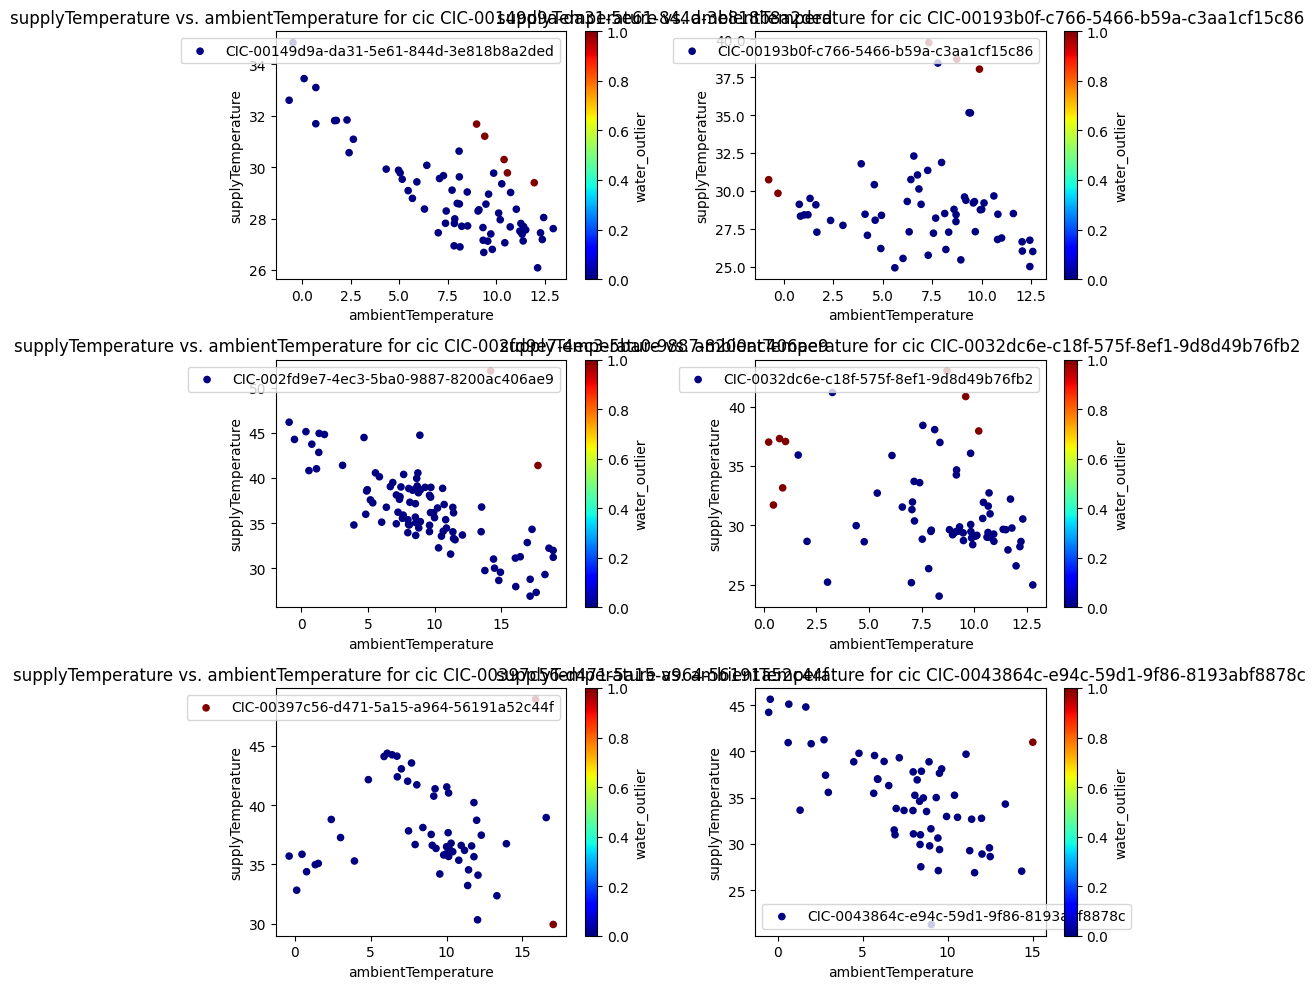

In [90]:
# plot supplyTemperature vs. ambientTemperature for several cic's using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
cics = df_cics['cic_id'].unique()

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

for i, cic in enumerate(cics[:6]):  # Change the slice to select the first 6 cics
    df_cic = df_cics[df_cics['cic_id'] == cic]
    df_cic.plot(kind='scatter', x='ambientTemperature', y='supplyTemperature', 
                c='water_outlier', cmap='jet', ax=axs[i], label=cic, colorbar=True)
    axs[i].set_title(f'supplyTemperature vs. ambientTemperature for cic {cic}')
    axs[i].legend()

plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()



# fig = go.Figure()
# for cic in cics[:5]:
#     df_cic = df_cics[df_cics['cic_id'] == cic]
#     fig.add_trace(go.Scatter(x=df_cic['ambientTemperature'], y=df_cic['supplyTemperature'], mode='markers', name=cic))
# fig.update_layout(title='supplyTemperature vs. ambientTemperature for several cic\'s')
# fig.show()

9162

In [97]:
# create a dataframe with one row per cic id
df_cics_train = pd.DataFrame(columns=['cic_id', 'water_slope', 'water_intercept', 
                                      'water_rmse', 'n_wt', 'heat_slope', 'heat_intercept',
                                      'heat_rmse', 'n_hd'])
# create a column with each unique cic id
df_cics_train['cic_id'] = df_cics['cic_id'].unique()


# make an skLearn linear regression model
model = LinearRegression()
# import calculation of rmse for linear regression
from sklearn.metrics import mean_squared_error

for cic in df_cics_train['cic_id']:
    # apply linearRegression model to each cic
    df_cic_wt = df_cics[(df_cics['cic_id'] == cic) & (df_cics['water_outlier'] == 0)]
    
    # fit the model for water supply temperature
    if len(df_cic_wt.index) >= 10:
        model.fit(df_cic_wt[['ambientTemperature']], df_cic_wt['supplyTemperature'])
        rmse_w = mean_squared_error(df_cic_wt['supplyTemperature'], 
                                model.predict(df_cic_wt[['ambientTemperature']]), 
                                squared=False)
        # add values to dataframe
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'water_slope'] = model.coef_[0]
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'water_intercept'] = model.intercept_
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'water_rmse'] = rmse_w
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'n_wt'] = len(df_cic_wt.index)

    # fit model for heat demand
    df_cic_hd = df_cics[(df_cics['cic_id'] == cic) & (df_cics['heat_outlier'] == 0)]
    if len(df_cic_hd.index) >= 10:
        X = df_cic_hd['ambientTemperature'].to_numpy().reshape(-1, 1)
        y = df_cic_hd['Q_house'].to_numpy()
        modelHeatDemand = TheilSenRegressor(random_state=0).fit(X, y)
        rmse_h = mean_squared_error(df_cic_hd['Q_house'], 
                                modelHeatDemand.predict(df_cic_hd[['ambientTemperature']]), 
                                squared=False)

        # add values to dataframe
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'heat_slope'] = list(modelHeatDemand.coef_)[0]
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'heat_intercept'] = modelHeatDemand.intercept_
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'heat_rmse'] = rmse_h
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'n_hd'] = len(df_cic_hd.index)


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but TheilSenRegressor was fitted without feature names

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but TheilSenRegressor was fitted without feature names

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but TheilSenRegressor was fitted without feature names

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but TheilSenRegressor was fitted without feature names

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but TheilSenRegressor was fitted without feature names

/User

In [92]:
# scatter plot each of three added columns of df_cics_train
from pandas.plotting import scatter_matrix

attributes = ["water_slope", 'water_intercept', 'water_rmse', 'n_samples']
scatter_matrix(df_cics_train[attributes], figsize=(12, 8), alpha=0.1)
plt.show()


ValueError: Number of columns must be a positive integer, not 0

<Figure size 1200x800 with 0 Axes>

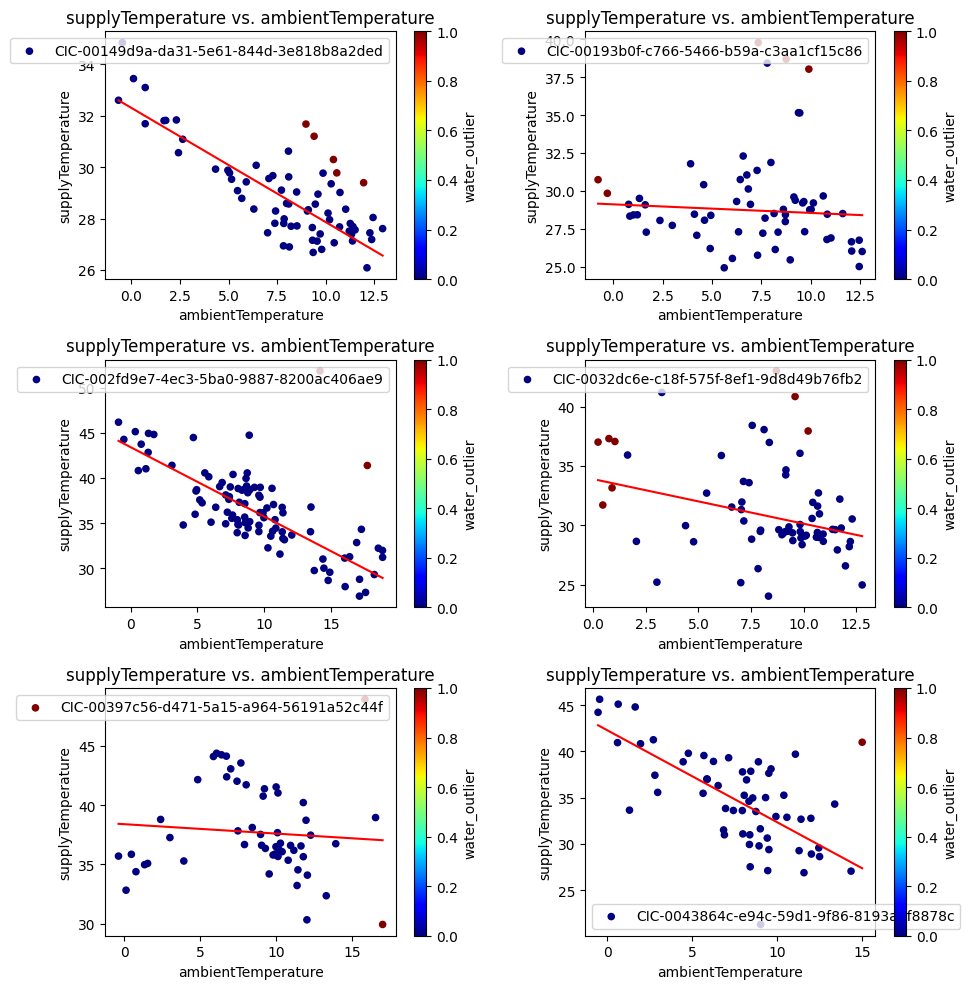

In [112]:
# plot supplyTemperature vs. ambientTemperature for several cic's using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
cics = df_cics['cic_id'].unique()

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

for i, cic in enumerate(cics[:6]):  # Change the slice to select the first 6 cics
    df_cic = df_cics[df_cics['cic_id'] == cic]
    df_cic.plot(kind='scatter', x='ambientTemperature', y='supplyTemperature', 
                c='water_outlier', cmap='jet', ax=axs[i], label=cic)
    axs[i].set_title(f'supplyTemperature vs. ambientTemperature')
    # axs[i].set_suptitle(cic)
    axs[i].legend()
    # add line based on linear regression model
    x = np.linspace(df_cic['ambientTemperature'].min(), df_cic['ambientTemperature'].max(), 100)
    y = df_cics_train[df_cics_train['cic_id'] == cic]['water_slope'].values[0] * x + df_cics_train[df_cics_train['cic_id'] == cic]['water_intercept'].values[0]
    axs[i].plot(x, y, '-r')

plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()



## Extrapolate to -10 and -5 and 0 degrees


In [106]:
# calculate heat demand and water supply temperature for each cic
temperature = -10
df_results = pd.DataFrame(columns=['cic_id','heat_demand','supply_temperature'])
df_results['cic_id'] = df_cics_train['cic_id'].unique()
df_results['heat_demand'] = df_results['cic_id'].apply(lambda x: heat_demand_model(temperature, 
                                                                                    df_cics_train[df_cics_train['cic_id'] == x]['heat_slope'].values[0], 
                                                                                    df_cics_train[df_cics_train['cic_id'] == x]['heat_intercept'].values[0]))
df_results['supply_temperature'] = df_results['cic_id'].apply(lambda x: heat_demand_model(temperature,
                                                                                          df_cics_train[df_cics_train['cic_id'] == x]['water_slope'].values[0], 
                                                                                        df_cics_train[df_cics_train['cic_id'] == x]['water_intercept'].values[0]))
                                                                                                

<Axes: xlabel='supply_temperature', ylabel='heat_demand'>

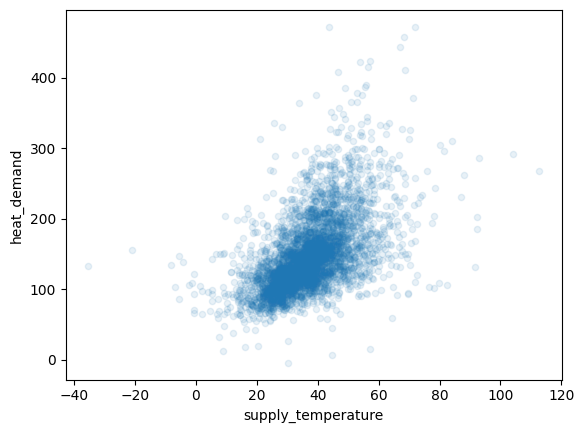

In [110]:
df_results.plot(kind='scatter', x='supply_temperature', y='heat_demand', alpha=0.1)